In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [3]:
# Load the dataset
df = pd.read_csv('Raw_Data/Raw_credit_card_transactions.csv')

In [4]:
# Initial Data Overview
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [5]:
# Step 1: Drop Unnecessary Columns
# These columns won't help in predicting fraud, so we'll drop them.
df = df.drop(columns=['Unnamed: 0', 'trans_num', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'unix_time'])
df.head()

,trans_date_trans_time,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,merch_zipcode
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0,28705.0
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0,NaN
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0,83236.0
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,Patent attorney,1967-01-12,47.034331,-112.561071,0,NaN
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,0,22844.0


In [6]:
# Step 2: Handle Missing Values
# 'merch_zipcode' has some missing values, we'll fill them with the most common value (mode)
df['merch_zipcode'].fillna(df['merch_zipcode'].mode()[0], inplace=True)

C:\Users\91729\AppData\Local\Temp\ipykernel_2192\3100330883.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['merch_zipcode'].fillna(df['merch_zipcode'].mode()[0], inplace=True)


In [7]:
# Step 3: Convert Data Types
# Convert 'trans_date_trans_time' to datetime to extract useful features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')  # Convert dob to datetime and handle errors

In [8]:
# Step 4: Feature Engineering - Continue from last update
# Ensure 'trans_date_trans_time' is a datetime object, and extract 'age' from 'dob'
df['age'] = (df['trans_date_trans_time'].dt.year - df['dob'].dt.year).astype(int)

In [9]:
# Drop the original datetime and date of birth columns after creating 'age'
df = df.drop(columns=['trans_date_trans_time', 'dob'])
df

,merchant,category,amt,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,merch_zipcode,age
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,28705.0,31
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,43436.0,41
2,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,0,83236.0,57
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0,43436.0,52
4,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0,22844.0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,fraud_Reichel Inc,entertainment,15.56,M,37.7175,-112.4777,258,Geoscientist,36.841266,-111.690765,0,43436.0,59
1296671,fraud_Abernathy and Sons,food_dining,51.70,M,39.2667,-77.5101,100,"Production assistant, television",38.906881,-78.246528,0,22630.0,41
1296672,fraud_Stiedemann Ltd,food_dining,105.93,M,32.9396,-105.8189,899,Naval architect,33.619513,-105.130529,0,88351.0,53
1296673,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,M,43.3526,-102.5411,1126,Volunteer coordinator,42.788940,-103.241160,0,69367.0,40


In [10]:
# Drop high-cardinality columns that might not be useful for this basic model
df = df.drop(columns=['merchant', 'job'])

In [11]:
# Step 5: Encode Essential Categorical Variables
# Perform one-hot encoding on remaining categorical columns
df = pd.get_dummies(df, columns=['category', 'gender'], drop_first=True)

In [12]:
# Convert all columns to numeric if any remain as objects after encoding
df = df.apply(pd.to_numeric, errors='coerce')

In [13]:
# Check for any non-numeric columns left
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)  # Should be empty

Non-numeric columns: Index(['category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M'],
      dtype='object')


In [14]:
# Convert all columns in df to numeric explicitly
df = df.apply(lambda col: pd.to_numeric(col, errors='ignore') if col.dtype == 'object' else col)

In [15]:
# Check if there are still any non-numeric columns
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns after conversion attempt:", non_numeric_cols)  # Should be empty now

Non-numeric columns after conversion attempt: Index(['category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M'],
      dtype='object')


In [17]:
# If any non-numeric columns remain, drop them (usually there shouldn’t be any after this step)
if len(non_numeric_cols) > 0:
    X = X.drop(columns=non_numeric_cols)
    print(f"Dropped columns: {non_numeric_cols}")

Dropped columns: Index(['category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M'],
      dtype='object')


In [18]:
# Step 6: Train-test split
X_subset, _, y_subset, _ = train_test_split(X, y, test_size=0.8, random_state=42)

In [19]:
# Train-test split on subset due to memory constraints
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.3, random_state=42)

In [20]:
# Train Logistic Regression Model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [21]:
# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [22]:
# Step 7: Evaluate Model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[77292    50]
 [  459     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     77342
           1       0.00      0.00      0.00       459

    accuracy                           0.99     77801
   macro avg       0.50      0.50      0.50     77801
weighted avg       0.99      0.99      0.99     77801


ROC AUC Score: 0.8188719440896555


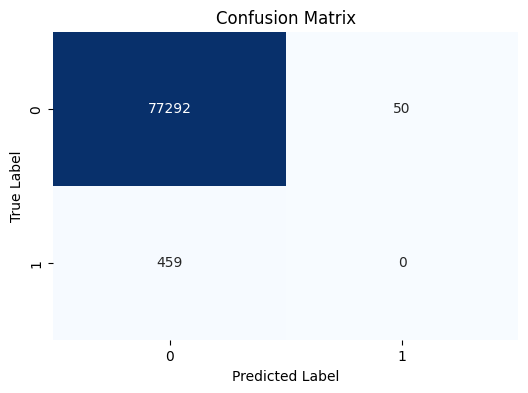

In [23]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()